In [1]:
!pip install --upgrade --quiet langchain-core langchain-community langgraph langchain-groq pydantic sqlalchemy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.9 MB/s eta 0:00:00


In [2]:
import os
import sqlite3
import random
from typing import TypedDict, Literal
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
GROQ_API_KEY = os.environ.get("GROQ_API_KEY")
if not GROQ_API_KEY:
    # Fallback for Colab/Jupyter environments
    try:
        from google.colab import userdata
        GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    except (ImportError, KeyError):
        print("Please provide your Groq API key.")
        GROQ_API_KEY = ""

In [4]:
# Setup the LLM
llm = ChatGroq(model="llama3-8b-8192", temperature=0, api_key=GROQ_API_KEY)

In [5]:
#DATABASE SETUP
# We'll use an in-memory SQLite database to store the feedback.

DB_FILE = "customer_feedback.db"
if os.path.exists(DB_FILE):
    os.remove(DB_FILE)

conn = sqlite3.connect(DB_FILE)
cursor = conn.cursor()

# Create the table to store feedback
cursor.execute("""
CREATE TABLE service_reviews (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_name TEXT NOT NULL,
    service_type TEXT NOT NULL,
    booking_id TEXT UNIQUE,
    call_transcript TEXT,
    extracted_feedback TEXT,
    sentiment TEXT,
    review_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
""")
conn.commit()
print("Database 'service_reviews' created successfully.")


Database 'service_reviews' created successfully.


In [6]:
#DEFINE THE STATE AND SCHEMAS

class ExtractedFeedback(BaseModel):
    """Schema for the data extracted from the call transcript."""
    customer_feedback: str = Field(..., description="The verbatim feedback provided by the customer about their service experience.")

class SentimentAnalysis(BaseModel):
    """Schema for the sentiment analysis of the feedback."""
    sentiment: Literal["Satisfied", "Dissatisfied", "Neutral"] = Field(..., description="The overall sentiment of the customer's feedback.")

class AgentState(TypedDict):
    """The state of our graph."""
    booking_id: str
    customer_name: str
    service_type: str
    call_transcript: str
    extracted_data: ExtractedFeedback
    sentiment_analysis: SentimentAnalysis
    db_update_status: str


In [7]:
def call_simulation_node(state: AgentState):
    """
    Simulates a phone call to the customer and generates a transcript.
    In a real system, this would be replaced by a telephony API call.
    """
    print("\n➡️ Simulating customer feedback call...")
    customer_name = state['customer_name']
    service_type = state['service_type']

    # Generate a realistic-sounding conversation
    prompt = f"""
    Generate a short, realistic phone call transcript between an AI agent and a customer named {customer_name}.
    The AI is calling to get feedback about a recent '{service_type}' service.
    Make the customer's feedback clear. For example, they could be happy with the punctuality but unhappy with the quality, or vice versa.
    """
    transcript = llm.invoke(prompt).content
    print("✅ Call simulation complete.")
    return {"call_transcript": transcript}


def feedback_extraction_node(state: AgentState):
    """
    Extracts the core feedback from the call transcript using a structured output LLM.
    """
    print("\n➡️ Extracting feedback from transcript...")
    feedback_extractor_llm = llm.with_structured_output(ExtractedFeedback)
    prompt = [
        SystemMessage(content="You are an expert at analyzing conversations. Your task is to extract the customer's core feedback about their service experience from the provided call transcript."),
        HumanMessage(content=state["call_transcript"]),
    ]
    extracted_data = feedback_extractor_llm.invoke(prompt)
    print("✅ Feedback extracted successfully.")
    return {"extracted_data": extracted_data}


def sentiment_analysis_node(state: AgentState):
    """
    Analyzes the extracted feedback to determine the customer's sentiment.
    """
    print("\n➡️ Analyzing sentiment...")
    sentiment_analyzer_llm = llm.with_structured_output(SentimentAnalysis)
    prompt = [
        SystemMessage(content="You are an expert sentiment analyst. Based on the following customer feedback, classify the sentiment as 'Satisfied', 'Dissatisfied', or 'Neutral'."),
        HumanMessage(content=state["extracted_data"].customer_feedback),
    ]
    sentiment_analysis = sentiment_analyzer_llm.invoke(prompt)
    print(f"✅ Sentiment analyzed as: '{sentiment_analysis.sentiment}'")
    return {"sentiment_analysis": sentiment_analysis}


def database_update_node(state: AgentState):
    """
    Saves the collected information to the SQLite database.
    """
    print("\n➡️ Updating database...")
    local_conn = sqlite3.connect(DB_FILE)
    local_cursor = local_conn.cursor()
    try:
        local_cursor.execute(
            """
            INSERT INTO service_reviews (booking_id, customer_name, service_type, call_transcript, extracted_feedback, sentiment)
            VALUES (?, ?, ?, ?, ?, ?)
            """,
            (
                state['booking_id'],
                state['customer_name'],
                state['service_type'],
                state['call_transcript'],
                state['extracted_data'].customer_feedback,
                state['sentiment_analysis'].sentiment,
            )
        )
        local_conn.commit()
        print("✅ Database updated successfully.")
        return {"db_update_status": "Success"}
    except sqlite3.Error as e:
        print(f"❌ Database update failed: {e}")
        return {"db_update_status": f"Failed: {e}"}
    finally:
        local_conn.close()


In [8]:
# CONSTRUCT THE GRAPH

workflow = StateGraph(AgentState)

# Add the nodes
workflow.add_node("call_simulation", call_simulation_node)
workflow.add_node("feedback_extraction", feedback_extraction_node)
workflow.add_node("sentiment_analysis", sentiment_analysis_node)
workflow.add_node("database_update", database_update_node)

# Define the graph's flow
workflow.set_entry_point("call_simulation")
workflow.add_edge("call_simulation", "feedback_extraction")
workflow.add_edge("feedback_extraction", "sentiment_analysis")
workflow.add_edge("sentiment_analysis", "database_update")
workflow.add_edge("database_update", END)

# Compile the graph
app = workflow.compile()


📊 Customer Feedback Agent Workflow:


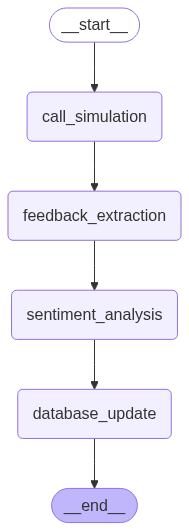

In [9]:
# Visualize the graph
print("\n📊 Customer Feedback Agent Workflow:")
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
# EXECUTION LOGIC

def run_feedback_agent(customer_name: str, service_type: str):
    """
    Runs the full customer feedback agent workflow for a given booking.
    """
    booking_id = f"BK-{random.randint(1000, 9999)}"
    print("\n" + "="*50)
    print(f"🚀 Starting New Feedback Cycle for Booking ID: {booking_id}")
    print(f"   - Customer: {customer_name}")
    print(f"   - Service: {service_type}")
    print("="*50)

    initial_state = {
        "booking_id": booking_id,
        "customer_name": customer_name,
        "service_type": service_type,
    }

    final_state = app.invoke(initial_state)

    print("\n\n" + "-"*30)
    print("      WORKFLOW COMPLETE")
    print("-"*30 + "\n")
    print(f"Booking ID: {final_state['booking_id']}")
    print(f"Sentiment: {final_state['sentiment_analysis'].sentiment}")
    print(f"Feedback: \"{final_state['extracted_data'].customer_feedback}\"")
    print(f"Database Status: {final_state['db_update_status']}")
    print("\n--- Full Call Transcript ---")
    print(final_state['call_transcript'])
    print("-" * 28)

In [11]:
# RUN EXAMPLES
run_feedback_agent(customer_name="Shubham", service_type="AC Repair")
run_feedback_agent(customer_name="Priya", service_type="House Cleaning")

# Verify the data in the database
with sqlite3.connect(DB_FILE) as conn:
    cursor = conn.cursor()
    print("\n\n🔍 Verifying data in 'service_reviews' table...")
    cursor.execute("SELECT booking_id, customer_name, sentiment FROM service_reviews;")
    results = cursor.fetchall()
    for row in results:
        print(f"   - {row}")

# Close the initial database connection
conn.close()


🚀 Starting New Feedback Cycle for Booking ID: BK-4976
   - Customer: Shubham
   - Service: AC Repair

➡️ Simulating customer feedback call...
✅ Call simulation complete.

➡️ Extracting feedback from transcript...
✅ Feedback extracted successfully.

➡️ Analyzing sentiment...
✅ Sentiment analyzed as: 'Dissatisfied'

➡️ Updating database...
✅ Database updated successfully.


------------------------------
      WORKFLOW COMPLETE
------------------------------

Booking ID: BK-4976
Sentiment: Dissatisfied
Feedback: "The technician was punctual and professional, but the repair work was not done correctly. The technician seemed to be in a rush and didn't take the time to properly diagnose the issue. I was expecting a more thorough job."
Database Status: Success

--- Full Call Transcript ---
Here is a short, realistic phone call transcript between an AI agent and a customer named Shubham:

**AI Agent:** Hello, Shubham. Thank you for taking my call. I'm calling from XYZ Home Services to get yo